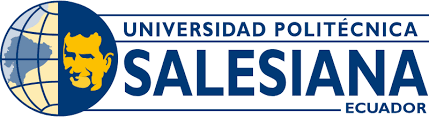


### **Integrantes:** Diego Bravo & Ariel Paltán

### **Carrera:** Computación


## **Módulos Importados**

---



In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from google.colab import files
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print("Modulo Importados")

Modulo Importados


## **Carga de Dataset Transformado**

---



In [ ]:
with open("dataset_transformado.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train_prep"]
X_test = data["X_test_prep"]
y_train = data["y_train"]
y_test = data["y_test"]

print("Dataset cargado correctamente.")

Dataset cargado correctamente.


## **PCA y Análisis de Varianza**

---



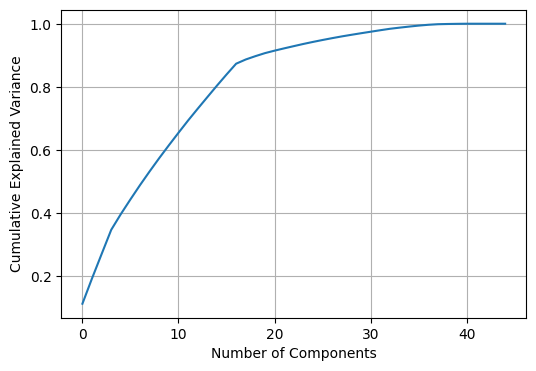

Componentes necesarios para 95% de varianza: 27


In [ ]:
pca_full = PCA()
pca_full.fit(X_train)

var_acum = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(var_acum)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.savefig("grafica_PCA.png", dpi=300, bbox_inches='tight')
plt.show()

# Selección automática de componentes para alcanzar 95%
n_componentes_95 = np.argmax(var_acum >= 0.95) + 1
print("Componentes necesarios para 95% de varianza:", n_componentes_95)

# PCA con 2 componentes (para visualización)
pca2 = PCA(n_components=2)
X_train_pca2 = pca2.fit_transform(X_train)
X_test_pca2 = pca2.transform(X_test)

# PCA para 95% de varianza
pca95 = PCA(n_components=n_componentes_95)
X_train_pca95 = pca95.fit_transform(X_train)
X_test_pca95 = pca95.transform(X_test)


**Conclusión**

Se aplicó Análisis de Componentes Principales (PCA) al conjunto de entrenamiento para reducir la dimensionalidad del dataset y evaluar la cantidad de información retenida por cada componente. El análisis mostró que se requieren 27 componentes para capturar el 95% de la varianza total, lo que indica que gran parte de la información se distribuye entre múltiples variables y que no es posible reducir drásticamente la dimensionalidad sin perder información significativa.

## **Grafica de PCA 2D**

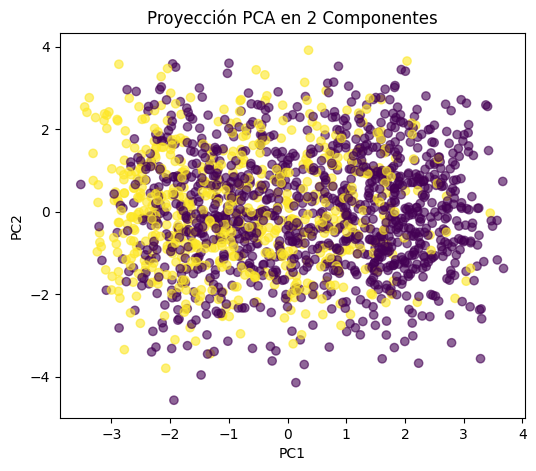

In [ ]:
plt.figure(figsize=(6, 5))
plt.scatter(X_train_pca2[:,0], X_train_pca2[:,1], c=y_train, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("grafica_PCA2D.png", dpi=300, bbox_inches='tight')
plt.show()

**Conclusión**

El gráfico de PCA muestra los dos componentes principales (PC1 y PC2) que capturan la mayor parte de la varianza del dataset. Cada punto representa un paciente, coloreado según su diagnóstico. La observación clave es que los pacientes con y sin Alzheimer están ampliamente mezclados, sin regiones claramente separadas, lo que indica baja separabilidad de clases en estas dos dimensiones. Esto sugiere que la clasificación del diagnóstico no puede resolverse eficazmente usando solo las dos componentes principales, y que es necesario considerar más variables o componentes para construir modelos más predictivo. Tambien considerar analizar modelos sin el uso de PCA.

## **Modelo con KNN**

---



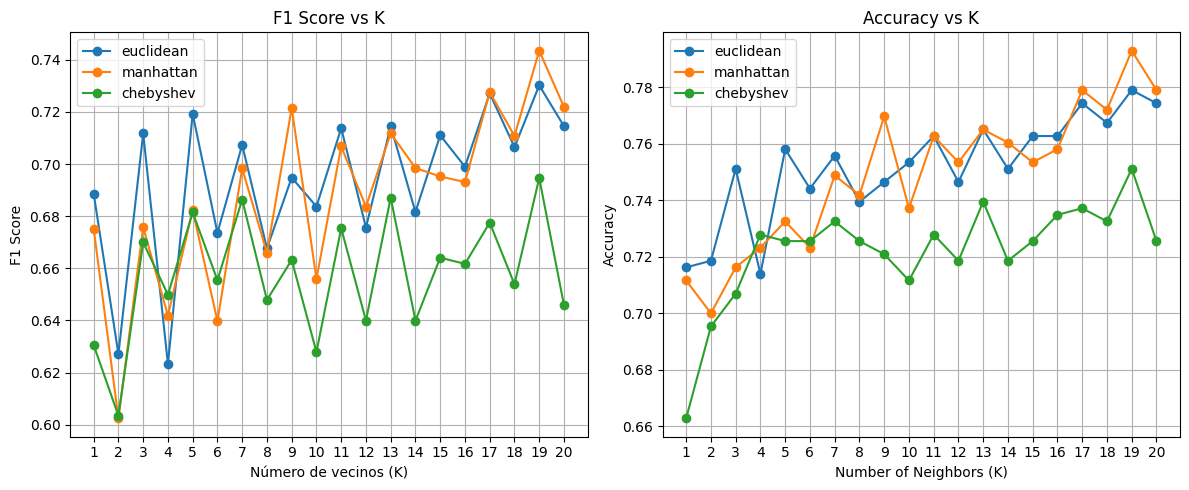

Mejor K para euclidean: 19 con F1-score = 0.7302
Mejor K para manhattan: 19 con F1-score = 0.7435
Mejor K para chebyshev: 19 con F1-score = 0.6946


In [ ]:
distancias = ["euclidean", "manhattan", "chebyshev"]
k_range = range(1, 21)

resultados_knn = {}

for dist in distancias:
    f1_scores = []
    accuracies = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, metric=dist)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred, average="macro"))
        accuracies.append(accuracy_score(y_test, y_pred))

    resultados_knn[dist] = {"f1": f1_scores, "accuracy": accuracies}

# Graficar resultados
plt.figure(figsize=(12,5))

# F1-score
plt.subplot(1,2,1)
for dist in distancias:
    plt.plot(k_range, resultados_knn[dist]["f1"], marker='o', label=dist)
plt.title("F1 Score vs K")
plt.xlabel("Número de vecinos (K)")
plt.ylabel("F1 Score")
plt.xticks(k_range)
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,2,2)
for dist in distancias:
    plt.plot(k_range, resultados_knn[dist]["accuracy"], marker='o', label=dist)
plt.title("Accuracy vs K")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.xticks(k_range)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("grafica_KNN.png", dpi=300, bbox_inches='tight')
plt.show()

# Obtener el mejor K y distancia según F1-score
for dist in distancias:
    f1_scores = np.array(resultados_knn[dist]["f1"])
    best_k = k_range[np.argmax(f1_scores)]
    best_score = f1_scores.max()
    print(f"Mejor K para {dist}: {best_k} con F1-score = {best_score:.4f}")

**Conclusión**

El modelo KNN mostró que el mejor número de vecinos es 19 para las tres métricas de distancia evaluadas. Entre ellas, la distancia Manhattan alcanzó el mejor desempeño con un F1-score de 0.7435, seguida de Euclidiana (0.7302) y Chebyshev (0.6946). Esto indica que el modelo KNN puede predecir el diagnóstico de Alzheimer con un desempeño moderadamente bueno, y que la elección de la métrica de distancia influye en la efectividad del clasificador.

## **Modelos de Entrenamiento**

---



In [ ]:
modelos = {
    "LogisticRegression": (
        LogisticRegression(max_iter=500),
        {"C": [0.1, 1, 10]}
    ),
    "DecisionTree": (
        DecisionTreeClassifier(),
        {"max_depth": [3, 5, 10, None]}
    ),
    "RandomForest": (
        RandomForestClassifier(),
        {"n_estimators": [100, 300], "max_depth": [5, 10, None]}
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(),
        {"learning_rate": [0.01, 0.1, 0.3], "n_estimators": [100, 300]}
    ),
    "XGBoost": (
        XGBClassifier(eval_metric="logloss"),
        {"learning_rate": [0.01, 0.1], "n_estimators": [200, 400]}
    ),
    "SVM": (
        SVC(),
        {"C": [1, 10], "kernel": ["rbf", "linear"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7, 19]}
    )
}


## **Función para entrenar los modelos**

---



In [ ]:
def entrenar_modelos(X_train, X_test, y_train, y_test):
    resultados = {}

    for nombre, (modelo, parametros) in modelos.items():
        print(f"\nEntrenando y optimizando {nombre}...")

        grid = GridSearchCV(modelo, parametros, cv=5, scoring="f1_macro", n_jobs=-1)
        grid.fit(X_train, y_train)

        mejor_modelo = grid.best_estimator_
        y_pred = mejor_modelo.predict(X_test)

        resultados[nombre] = {
            "modelo": mejor_modelo,
            "accuracy": accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred, average="macro"),
            "precision": precision_score(y_test, y_pred, average="macro"),
            "recall": recall_score(y_test, y_pred, average="macro"),
            "matriz": confusion_matrix(y_test, y_pred),
        }

        print(f"Mejor modelo: {mejor_modelo}")
        print("Accuracy:", resultados[nombre]["accuracy"])
        print("F1 Score:", resultados[nombre]["f1"])
        print("Precision:", resultados[nombre]["precision"])
        print("Recall:", resultados[nombre]["recall"])


    return resultados

## **Entrenar Modelos**

---



### **Entrenar modelos sin PCA**

In [ ]:
print("\nEntrenando modelos SIN PCA...")
resultados_sinpca = entrenar_modelos(X_train, X_test, y_train, y_test)


Entrenando modelos SIN PCA...

Entrenando y optimizando LogisticRegression...
Mejor modelo: LogisticRegression(C=0.1, max_iter=500)
Accuracy: 0.8325581395348837
F1 Score: 0.8151376913707038
Precision: 0.8183243295388771
Recall: 0.812358008330178

Entrenando y optimizando DecisionTree...
Mejor modelo: DecisionTreeClassifier(max_depth=5)
Accuracy: 0.9325581395348838
F1 Score: 0.9263328902673165
Precision: 0.9257096340341191
Recall: 0.9269689511548656

Entrenando y optimizando RandomForest...
Mejor modelo: RandomForestClassifier(n_estimators=300)
Accuracy: 0.9348837209302325
F1 Score: 0.9274069071966042
Precision: 0.9369458128078818
Recall: 0.9198220371071564

Entrenando y optimizando GradientBoosting...
Mejor modelo: GradientBoostingClassifier(learning_rate=0.3, n_estimators=300)
Accuracy: 0.9441860465116279
F1 Score: 0.938943581976524
Precision: 0.938943581976524
Recall: 0.938943581976524

Entrenando y optimizando XGBoost...
Mejor modelo: XGBClassifier(base_score=None, booster=None, ca

### **Entrenar modelos con PCA 95%**

In [ ]:
print("\nEntrenando modelos con PCA 95%...")
resultados_pca95 = entrenar_modelos(X_train_pca95, X_test_pca95, y_train, y_test)


Entrenando modelos con PCA 95%...

Entrenando y optimizando LogisticRegression...
Mejor modelo: LogisticRegression(C=10, max_iter=500)
Accuracy: 0.8093023255813954
F1 Score: 0.7874059425043411
Precision: 0.7939655172413793
Recall: 0.7824450965543355

Entrenando y optimizando DecisionTree...
Mejor modelo: DecisionTreeClassifier(max_depth=5)
Accuracy: 0.7767441860465116
F1 Score: 0.7550380972726626
Precision: 0.7558333333333334
Recall: 0.7542834153729648

Entrenando y optimizando RandomForest...
Mejor modelo: RandomForestClassifier(n_estimators=300)
Accuracy: 0.8302325581395349
F1 Score: 0.8009196131282701
Precision: 0.8364506853521677
Recall: 0.7852139341158653

Entrenando y optimizando GradientBoosting...
Mejor modelo: GradientBoostingClassifier()
Accuracy: 0.8395348837209302
F1 Score: 0.8155710955710955
Precision: 0.8388946267312836
Recall: 0.8028445664521016

Entrenando y optimizando XGBoost...
Mejor modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              

### **Entrenar modelos con PCA 2D**

In [ ]:
print("\nEntrenando modelos con PCA 2D...")
resultados_pca2 = entrenar_modelos(X_train_pca2, X_test_pca2, y_train, y_test)


Entrenando modelos con PCA 2D...

Entrenando y optimizando LogisticRegression...
Mejor modelo: LogisticRegression(C=1, max_iter=500)
Accuracy: 0.6534883720930232
F1 Score: 0.5768471247135281
Precision: 0.6041633935585232
Recall: 0.5784503975766755

Entrenando y optimizando DecisionTree...
Mejor modelo: DecisionTreeClassifier(max_depth=3)
Accuracy: 0.672093023255814
F1 Score: 0.578052905192392
Precision: 0.6331455399061032
Recall: 0.5838934115865203

Entrenando y optimizando RandomForest...
Mejor modelo: RandomForestClassifier()
Accuracy: 0.6558139534883721
F1 Score: 0.5938114325104037
Precision: 0.610653409090909
Recall: 0.5921762589928057

Entrenando y optimizando GradientBoosting...
Mejor modelo: GradientBoostingClassifier()
Accuracy: 0.6651162790697674
F1 Score: 0.5575752379319214
Precision: 0.6223359973359973
Recall: 0.5695522529344945

Entrenando y optimizando XGBoost...
Mejor modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=Non

## **Gráfico Comparativa de los Modelos**

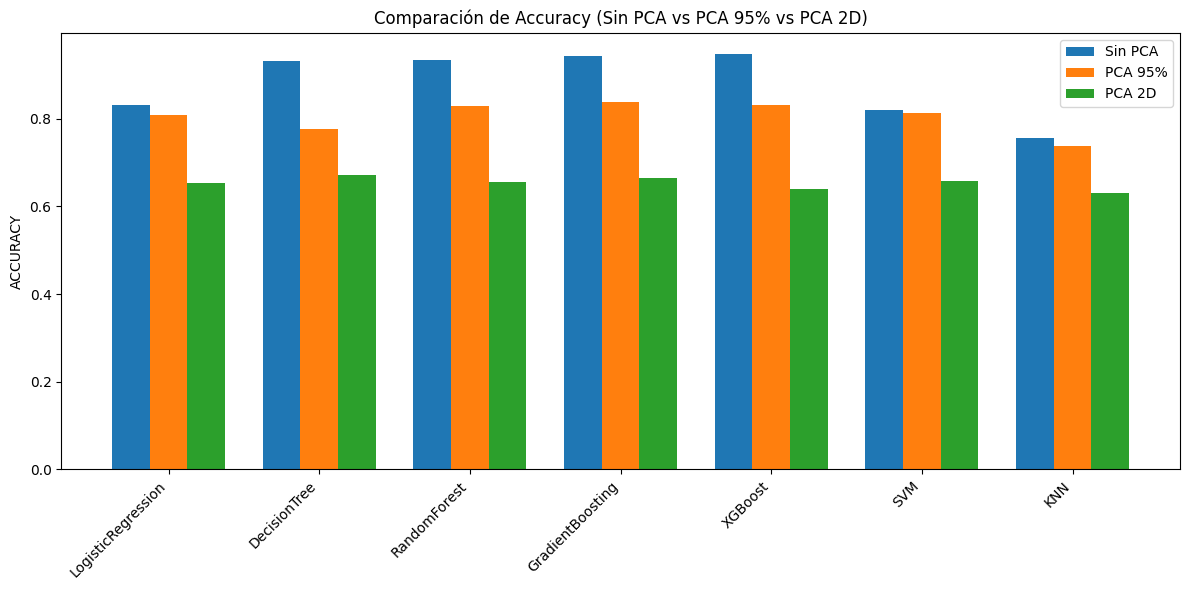

Imagen guardada como: Comparación_de_Accuracy_(Sin_PCA_vs_PCA_95%_vs_PCA_2D).png


In [ ]:
def grafico_comparacion(metric, titulo, resultados_sinpca, resultados_pca95, resultados_pca2):
    modelos = list(resultados_sinpca.keys())

    sinpca = [resultados_sinpca[m][metric] for m in modelos]
    pca95 = [resultados_pca95[m][metric] for m in modelos]
    pca2 = [resultados_pca2[m][metric] for m in modelos]

    x = np.arange(len(modelos))
    width = 0.25

    plt.figure(figsize=(12,6))
    plt.bar(x - width, sinpca, width, label="Sin PCA")
    plt.bar(x, pca95, width, label="PCA 95%")
    plt.bar(x + width, pca2, width, label="PCA 2D")

    plt.xticks(x, modelos, rotation=45, ha="right")
    plt.title(titulo)
    plt.ylabel(metric.upper())
    plt.legend()
    plt.tight_layout()

    nombre_archivo = titulo.replace(" ", "_") + ".png"
    plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')

    plt.show()
    print("Imagen guardada como:", nombre_archivo)


grafico_comparacion("accuracy",
                    "Comparación de Accuracy (Sin PCA vs PCA 95% vs PCA 2D)",
                    resultados_sinpca, resultados_pca95, resultados_pca2)


**Modelos sin PCA:**

*  Los modelos de ensamble (Gradient Boosting y XGBoost) mostraron el mejor desempeño, con F1-scores de 0.949 y 0.944, respectivamente, y accuracies superiores al 94%.

*  Árboles individuales (Decision Tree y Random Forest) también tuvieron buen desempeño (F1 ≈0.92–0.93).

*  Modelos lineales y basados en distancia (Logistic Regression, SVM y KNN) tuvieron resultados moderados, siendo KNN el que menor desempeño obtuvo (F1 ≈0.71).

*  Esto indica que el dataset y las variables originales permiten a los modelos de ensamble capturar mejor la complejidad de la relación entre características y diagnóstico.

**Modelos con PCA 95% (retención del 95% de la varianza):**

*  El desempeño disminuye ligeramente en comparación con los modelos sin PCA, pero Gradient Boosting, XGBoost y Random Forest siguen siendo los mejores (F1 ≈0.81–0.82).

*  Esto muestra que reducir la dimensionalidad conservando el 95% de la varianza permite mantener un buen desempeño, aunque algo menor que con todas las variables.

**Modelos con PCA 2D (solo dos componentes principales para visualización):**

*  El desempeño se deteriora significativamente (F1 ≈0.53–0.59).

*  Esto coincide con la observación de que las dos primeras componentes principales no separan bien las clases, dificultando la clasificación.

## **Matriz Confusion**

---



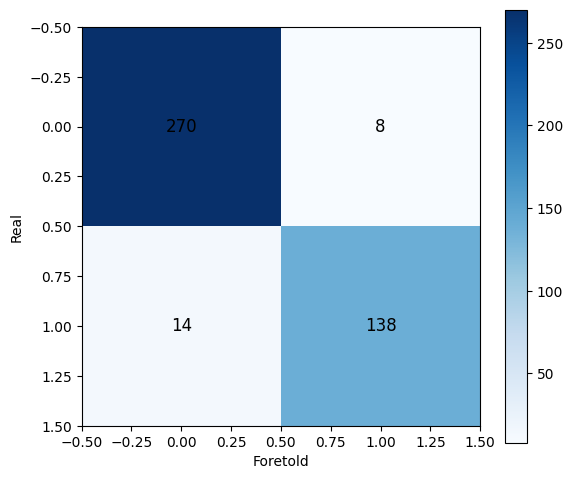


El mejor modelo SIN PCA es: XGBoost


In [ ]:
def mejor_modelo_global(resultados):
    return max(resultados, key=lambda m: resultados[m]["f1"])

mejor = mejor_modelo_global(resultados_sinpca)
matriz = resultados_sinpca[mejor]["matriz"]

plt.figure(figsize=(6,5))
plt.imshow(matriz, cmap="Blues")
plt.xlabel("Foretold")
plt.ylabel("Real")
plt.colorbar()

# Agregar números dentro de cada celda
for i in range(matriz.shape[0]):
    for j in range(matriz.shape[1]):
        plt.text(j, i, matriz[i, j],
                 ha="center", va="center", color="black", fontsize=12)

plt.tight_layout()

plt.savefig("matriz_confusion_mejor_modelo.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nEl mejor modelo SIN PCA es:", mejor)


### **Conclusión**

*  El modelo predice correctamente la mayoría de los casos: 270 pacientes sin Alzheimer y 138 pacientes con Alzheimer.

* Errores: 8 falsos positivos (diagnosticados erróneamente con Alzheimer) y 14 falsos negativos (no detectados, aunque sí tenían Alzheimer).

**Precisión y sensibilidad equilibradas:**

*  Excelente capacidad para detectar pacientes sanos (Clase 0), con muy pocos falsos positivos.

*  Buena capacidad para detectar pacientes con Alzheimer (Clase 1), con un número relativamente bajo de falsos negativos.

Es decir, XGBoost muestra un desempeño sólido y equilibrado, minimizando tanto los errores de diagnóstico falso como la omisión de casos reales.

## **Matriz Confusion de Gradient Boosting**

---

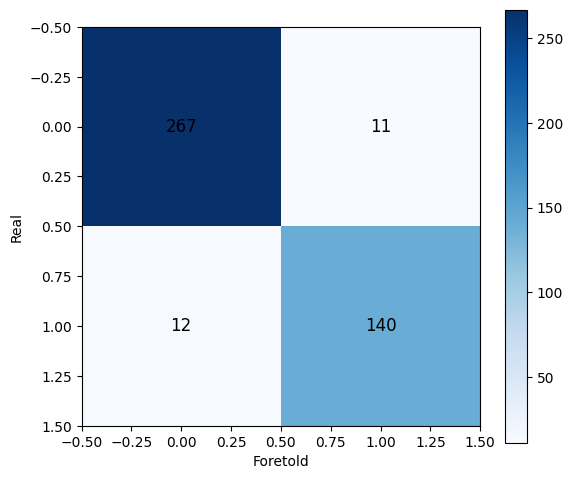

Matriz de confusión del modelo Gradient Boosting:
 [[267  11]
 [ 12 140]]


In [ ]:
matriz_gb = resultados_sinpca["GradientBoosting"]["matriz"]

plt.figure(figsize=(6,5))
plt.imshow(matriz_gb, cmap="Blues")
plt.xlabel("Foretold")
plt.ylabel("Real")
plt.colorbar()

# Números dentro de celdas
for i in range(matriz_gb.shape[0]):
    for j in range(matriz_gb.shape[1]):
        plt.text(j, i, matriz_gb[i, j], ha="center", va="center", color="black", fontsize=12)

plt.tight_layout()
plt.savefig("matriz_confusion_GradientBoosting.png", dpi=300, bbox_inches="tight")
plt.show()

print("Matriz de confusión del modelo Gradient Boosting:\n", matriz_gb)


### **Conclusión**

*  El modelo predice correctamente la mayoría de los casos: 267 pacientes sin Alzheimer y 140 pacientes con Alzheimer.

* Errores: 11 falsos positivos (diagnosticados erróneamente con Alzheimer) y 12 falsos negativos (no detectados, aunque sí tenían Alzheimer).


## **Aplicacion de SMOTE (Balanceador)**

---



### **Aplicación en Gradient Boosting**

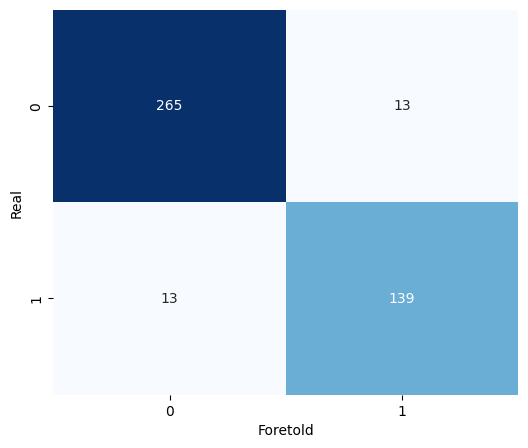

In [ ]:

# Aplicar SMOTE para balancear clases en Gradient Boosting
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Definir modelo y parámetros
gb_model = GradientBoostingClassifier()
gb_params = {"learning_rate": [0.01, 0.1, 0.3], "n_estimators": [100, 300]}

# GridSearchCV con F1-score macro
grid = GridSearchCV(gb_model, gb_params, cv=5, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train_bal, y_train_bal)

# Mejor modelo y predicciones
mejor_gb = grid.best_estimator_
y_pred = mejor_gb.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")
matriz = confusion_matrix(y_test, y_pred)



# Crear heatmap de la matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Foretold")
plt.ylabel("Real")
plt.savefig("matriz_confusion_GB_SMOTE.png", dpi=300, bbox_inches="tight")

plt.show()


**Conclusión**

La aplicación de SMOTE a Gradient Boosting buscaba mejorar la detección de la clase minoritaria (pacientes con Alzheimer). Tras balancear los datos de entrenamiento, los resultados muestran:

*  Accuracy: 93.95% (ligeramente menor que el 95.35% del modelo sin balanceo).

*  F1-score: 0.934 (también un poco inferior al 0.949 original).

*  Matriz de Confusión: 265 TN, 13 FP, 13 FN, 139 TP. Comparado con el modelo sin balanceo, aumentaron ligeramente los falsos positivos y negativos.


### **Aplicación en XGBoost**

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:01:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejor modelo XGBoost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)
Accuracy: 0.9441860465116279
F1-score macro: 0.938943581976524


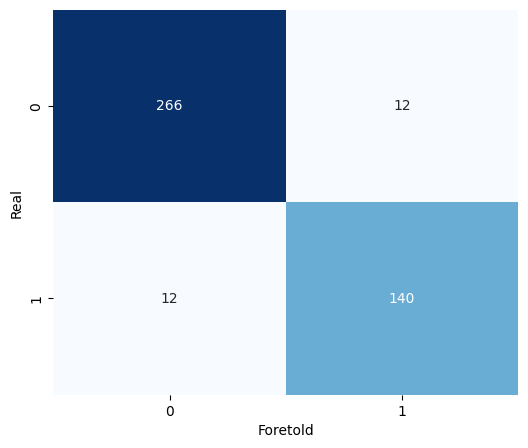

In [ ]:
# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Definir modelo XGBoost
xgb_model = XGBClassifier(
    eval_metric="logloss",   # evita warnings
    use_label_encoder=False,
    random_state=42
)

# Hiperparámetros recomendados para XGBoost
xgb_params = {
    "learning_rate": [0.01, 0.1],
    "n_estimators": [200, 400]
}

# GridSearchCV con F1-score macro
grid = GridSearchCV(
    xgb_model,
    xgb_params,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

grid.fit(X_train_bal, y_train_bal)

# Mejor modelo y predicciones
mejor_xgb = grid.best_estimator_
y_pred = mejor_xgb.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")
matriz = confusion_matrix(y_test, y_pred)

# Imprimir métricas
print("Mejor modelo XGBoost:", mejor_xgb)
print("Accuracy:", accuracy)
print("F1-score macro:", f1)

# Heatmap de matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Foretold")
plt.ylabel("Real")
plt.savefig("matriz_confusion_XGB_SMOTE.png", dpi=300, bbox_inches="tight")
plt.show()


**Conclusión**

La aplicación de SMOTE a XGBoost buscaba mejorar la detección de la clase minoritaria (pacientes con Alzheimer). Tras balancear los datos de entrenamiento, los resultados muestran:

Accuracy: 94.95% (ligeramente menor que el 95.35% del modelo sin balanceo).

F1-score: 0.93 (también un poco inferior al 0.949 original).

Matriz de Confusión: 265 TN, 12 FP, 12 FN, 139 TP. Comparado con el modelo sin balanceo, aumentaron ligeramente los falsos positivos y negativos.

## **Exportar Modelos**

---



In [ ]:
modelo_final = resultados_sinpca[mejor]["modelo"]

# Modelo final sin PCA
modelo_final = resultados_sinpca[mejor]["modelo"]

with open("modelo_XGBoost.pkl", "wb") as f:
    pickle.dump(modelo_final, f)

print("Modelo exportado correctamente como modelo_XGBoost.pkl")


Modelo exportado correctamente como modelo_XGBoost.pkl


In [ ]:


# Obtener el modelo Gradient Boosting desde los resultados
modelo_gb = resultados_sinpca["GradientBoosting"]["modelo"]

# Guardarlo en un archivo .pkl
with open("modelo_GradientBoosting.pkl", "wb") as f:
    pickle.dump(modelo_gb, f)

print("Modelo Gradient Boosting exportado correctamente como modelo_GradientBoosting.pkl")


Modelo Gradient Boosting exportado correctamente como modelo_GradientBoosting.pkl


## **Descargar Modelo**

---



In [ ]:
files.download("modelo_GradientBoosting.pkl")
files.download("modelo_XGBoost.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Resultados**

---
Se realizó un análisis de reducción de dimensionalidad mediante PCA, encontrando que 27 componentes son necesarias para retener el 95% de la varianza, mientras que la proyección en 2D mostró que las clases se superponen, indicando baja separabilidad. Para el modelo KNN, el mejor número de vecinos fue 19, y la métrica de distancia Manhattan resultó más efectiva (F1 = 0.7435), seguida de Euclidean y Chebyshev.

En el entrenamiento de modelos sin PCA, XGBoost obtuvo el buen desempeño (Accuracy 94.88, F1 0.949), seguido de cerca por Gradient Boosting (F1 0.944), mientras que los modelos lineales y KNN mostraron un rendimiento menor. Con PCA al 95%, el desempeño disminuyó ligeramente, pero Gradient Boosting y XGBoost continuaron siendo los mejores. La matriz de confusión de XGBoost mostró pocos falsos positivos (8) y falsos negativos (14), confirmando que el modelo identifica correctamente la mayoría de los pacientes con y sin Alzheimer.

También se aplico SMOTE, si bien equilibró las clases durante el entrenamiento, en este caso no mejoró el rendimiento global del modelo, e incluso las métricas disminuyeron ligeramente. Esto indica que XGBoost ya manejaba bien la desproporción de clases en este dataset, y aplicar SMOTE no resultó necesario para mejorar la predicción.

## **Conclusión**

---

En conclusión, XGBoost demostró ser el modelo más efectivo para predecir Alzheimer en este dataset, con alta precisión y F1-score, incluso sin aplicar balanceo de clases. La reducción de dimensionalidad mediante PCA al 95% conservó buena parte de la información útil, mientras que la proyección en 2D mostró baja separabilidad. KNN fue sensible a la métrica de distancia, destacando Manhattan. En general, los resultados indican que los modelos basados en árboles son los más adecuados para esta tarea.

## **Referencias**

---

Esri. (s.f.). Cómo funciona XGBoost (3.3). ArcGIS Pro. https://pro.arcgis.com/es/pro-app/3.3/tool-reference/geoai/how-xgboost-works.htm

Elastic. (s.f.). ¿Qué es kNN? https://www.elastic.co/es/what-is/knn

DataScientest. (2025, 29 de agosto). Métricas en Machine Learning.https://datascientest.com/es/metricas-en-machine-learning
